## Modules

In [1]:
# import basic modules
import datetime as dt
import pandas as pd
import os
import warnings
import numpy as np

In [2]:
# import all modules related to visualization
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [4]:
# filter warnings
warnings.filterwarnings("ignore")

## Import Data

In [5]:
# import the data and set the date as index
# Quarterly US GDP, seasonally adjusted annual rate
df = pd.read_csv(os.getcwd() + "/Data/GDPC1.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE")
# df = df["1947-01-01":"2019-10-01"]
print(df)

                GDPC1
DATE                 
1947-01-01   2033.061
1947-04-01   2027.639
1947-07-01   2023.452
1947-10-01   2055.103
1948-01-01   2086.017
...               ...
2019-10-01  19253.959
2020-01-01  19010.848
2020-04-01  17302.511
2020-07-01  18596.521
2020-10-01  18794.426

[296 rows x 1 columns]


## Data Overview

In [6]:
# function for visualization of the data
def graph_plot(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    # plot the original series
    ax1.plot(data, color = "darkblue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP")
    ax1.set_title("Original Series", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # plot the growth rates of the series
    ax2.plot(data.pct_change() * 100, color = "darkblue")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Real GDP Growth")
    ax2.set_title("Original Series (growth rates)", loc = "left")
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

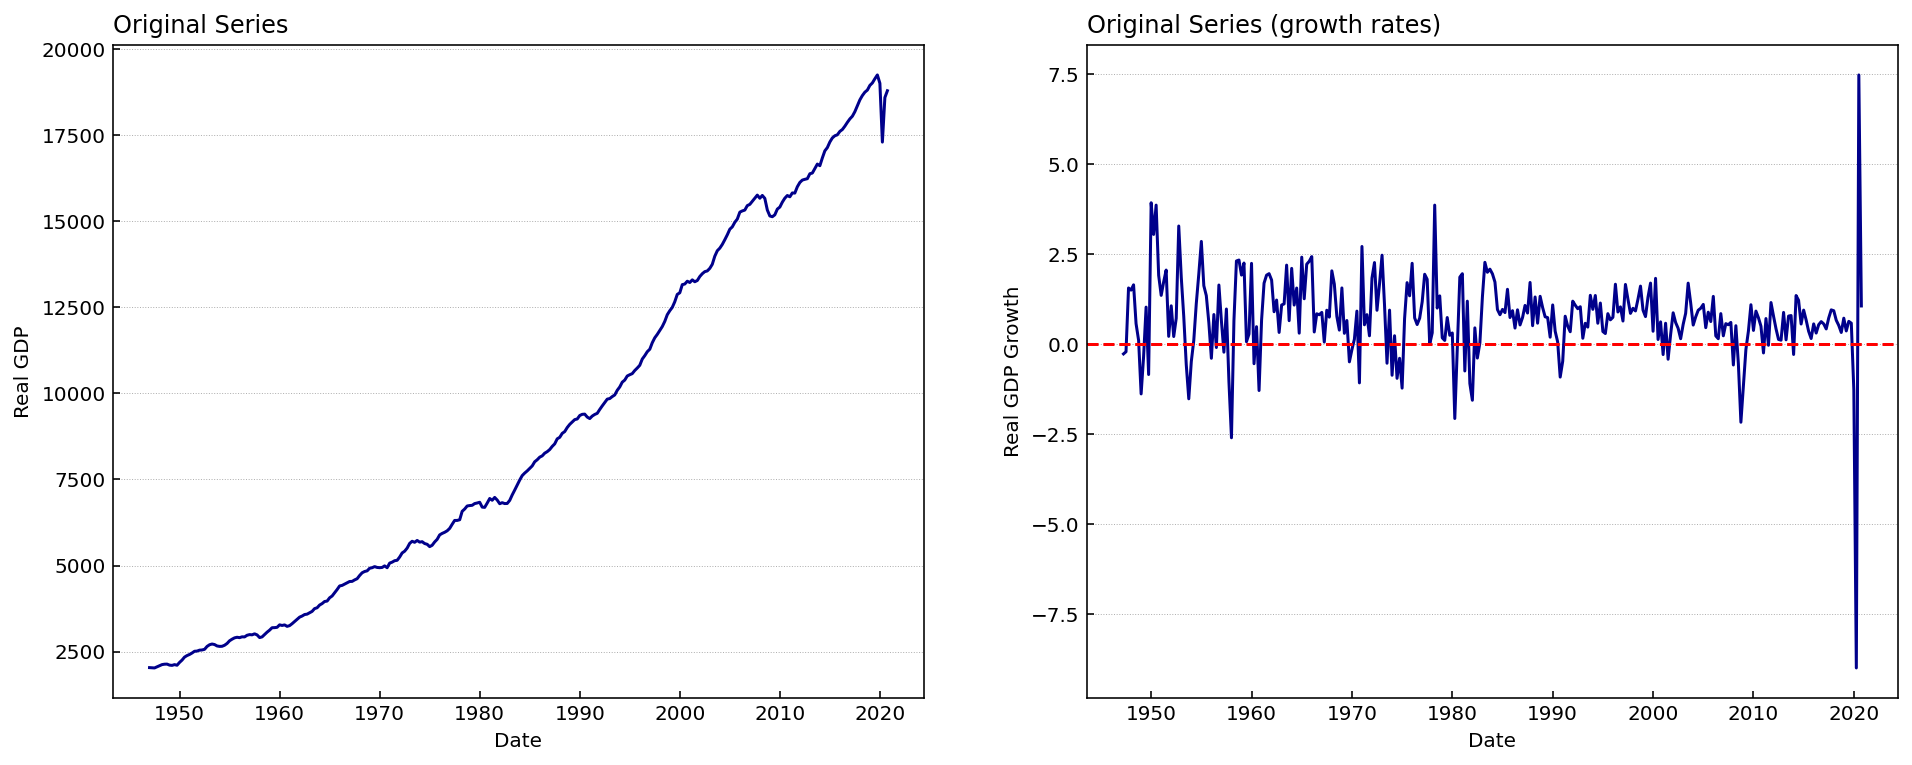

In [7]:
graph_plot(df)

In [8]:
# continue analyis with growth rates
df = df.pct_change().dropna() * 100

$$ y_{t} = \frac{y_{t}-y_{t-1}}{y_{t-1}} \cdot 100 $$

## Stationarity and Autocorrelation

In [9]:
# KPSS test
# null hypothesis : series is stationary
# alternate hypothesis : series not stationary (unit root)
# reject null hypothesis if p-value <= 0.05
def kpss_test(data):
    d = 0
    kpss_test = kpss(data.dropna())
    test_statistic, p_value, crit_value = kpss_test[0], kpss_test[1], kpss_test[3]["5%"]
    while test_statistic < crit_value:
        data = data.diff()
        kpss_test = kpss(data.dropna())
        test_statistic, p_value, crit_value = kpss_test[0], kpss_test[1], kpss_test[3]["5%"]
        d = d + 1
    else:
        print("Kwiatkowski-Phillips-Schmidt-Shin test results")
        print("-> test statistic: " + str(round(test_statistic, 2)))
        print("-> critical value: " + str(round(crit_value, 2)))
        print("-> p-value: " + str(round(p_value, 2)))
        print("-> order of differencing required: " + str(d))

In [10]:
kpss_test(df)

Kwiatkowski-Phillips-Schmidt-Shin test results
-> test statistic: 0.57
-> critical value: 0.46
-> p-value: 0.02
-> order of differencing required: 0


In [11]:
# ADF test
# null hypothesis : series not stationary (unit root)
# alternate hypothesis : series is stationary
# reject null hypothesis if p-value <= 0.05
def adf_test(data):
    d = 0
    adf_test = adfuller(data.dropna())
    test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["5%"]
    while test_statistic > crit_value:
        data = data.diff()
        adf_test = adfuller(data.dropna())
        test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["5%"]
        d = d + 1
    else:
        print("Augmented-Dickey-Fuller test results")
        print("-> test statistic: " + str(round(test_statistic, 2)))
        print("-> critical value: " + str(round(crit_value, 2)))
        print("-> p-value: " + str(round(p_value, 2)))
        print("-> order of differencing required: " + str(d))

In [12]:
adf_test(df)

Augmented-Dickey-Fuller test results
-> test statistic: -15.16
-> critical value: -2.87
-> p-value: 0.0
-> order of differencing required: 0


In [13]:
# select order of differencing suggested by adf & kpss test
d = 0

$$ \Delta y_{t} = y_{t} - y_{t-1} $$

In [14]:
# function for visualization of the autocorrelation
def ac_plot(data, d):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    # difference data if necessary
    i = 0
    while i != d:
        data = data.diff().dropna()
        i = i + 1
        
    # compute acf values and plot them
    plot_acf(data, ax = ax1, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax1.set_ylim(-0.15, 0.15)
    ax1.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax1.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax1.set_title("Autocorrelation Function", loc = "left")
    ax1.set_xlabel("Lags")
    ax1.set_ylabel("Autocorrelation")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # compute pacf values and plot them
    plot_pacf(data, ax = ax2, title = "", zero = False, color = "darkblue", 
              alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.set_ylim(-0.15, 0.15)
    ax2.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.set_title("Partial Autocorrelation Function", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Partial Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
            
    # return data
    return data

$$ r_{k} = \frac{\sum^{T}_{t=k+1}(y_{t}-\bar{y})(y_{t-k}-\bar{y})}{\sum^{T}_{t=1}(y_{t}-\bar{y})^2} $$

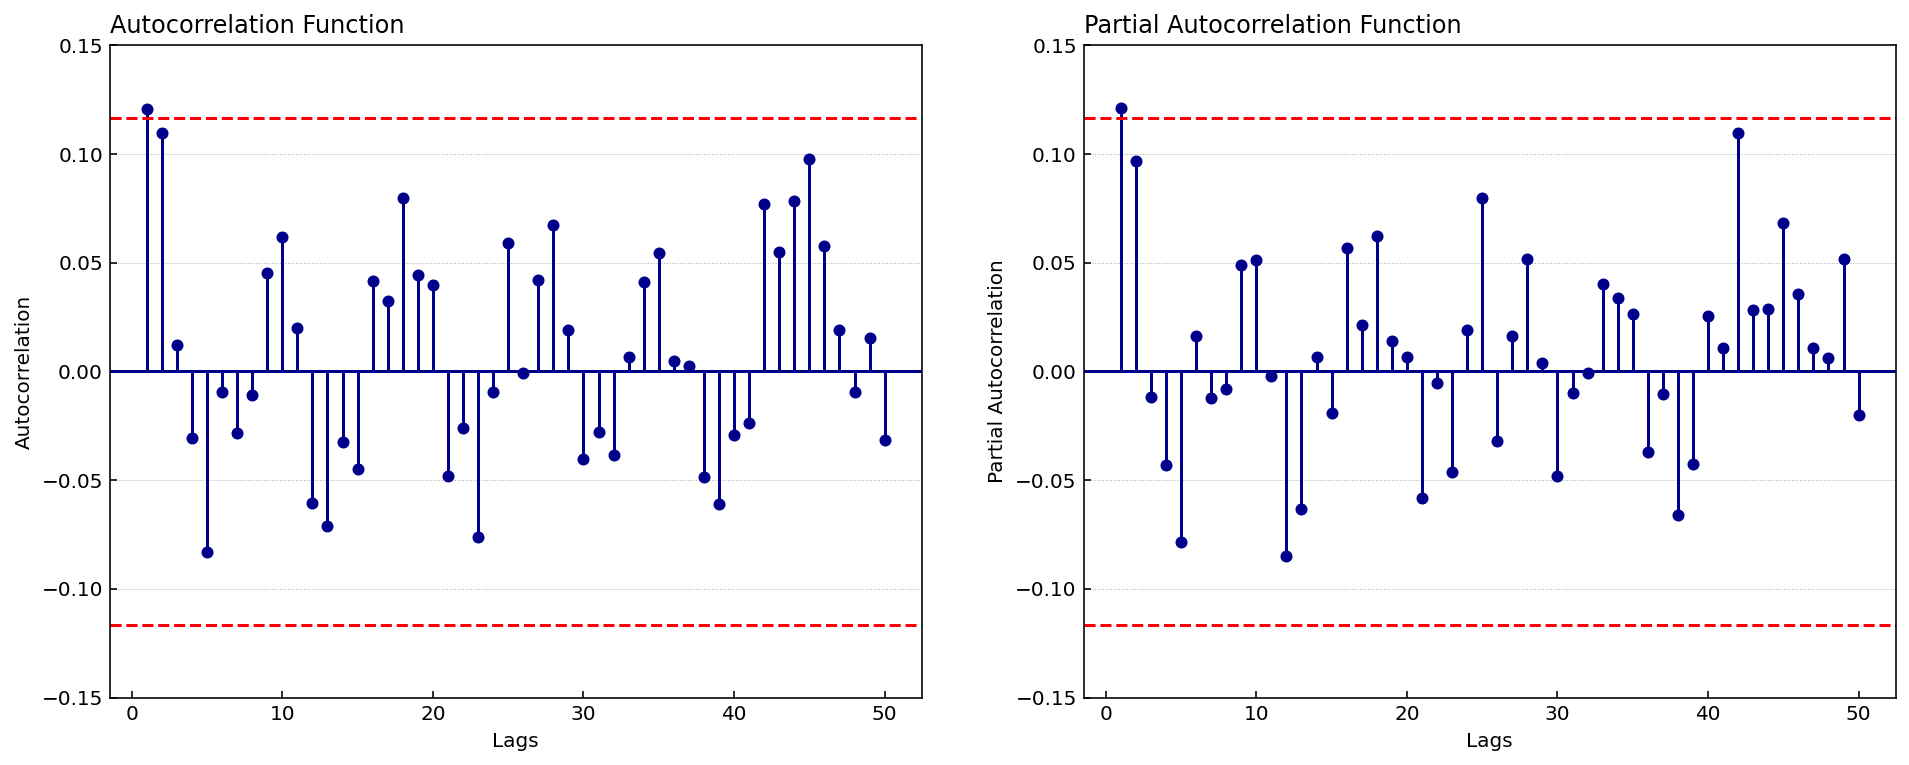

In [15]:
df_final = ac_plot(df, d)

In [16]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq = acorr_ljungbox(data, lags = 100)
    test_statistic, p_value = lbq[0].mean(), lbq[1].mean()
    print("Ljung-Box-Q test results")
    print("-> average test statistic: " + str(round(test_statistic, 2)))
    print("-> average p-value: "  + str(round(p_value, 2)))

$$ \text{Test Statistic:} \;\; Q = n(n+2)\sum^{h}_{k=1}\frac{r_{k}^2}{n-k} $$

In [17]:
lbq_test(df_final)

Ljung-Box-Q test results
-> average test statistic: 37.3
-> average p-value: 0.73


## Export Training and Test Data

In [18]:
# select the last two quarters as test data
# not including the covid-19 pandemic for now
X = df_final.copy()
training = X["1947-01-01":"2017-10-01"]
testing = X["2018-01-01":"2019-10-01"]

In [19]:
# save to current working directory
training.to_csv(os.getcwd() + "/Data/training.csv", index = True)
testing.to_csv(os.getcwd() + "/Data/testing.csv", index = True)